## RSNA Screening Mammography Cancer Detection 

### Team Members: Abdou Alrahman El-Ghazali

### Final Rank: [149](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/leaderboard?search=abdoue) (Top 9%)


# Table of Contents

- Introduction
- Libraries and Variables
- Data Preprocessing
- The Model
- Analysis
- Verifying Our Prediction Values For Deployment

# Introduction

Detecting breast cancer from mammograms is a difficult task even for seasoned radiologists. Cancerous masses can be small and can be hidden behind breast tissue. Even when a mass is visible, it's hard to determine whether it is cancerous just by looking at it. However, in some cases detection is still possible, and there are some features to look for in a mammogram:

- crab-like masses
- microcalcifications
- asymmetries and distortions
- skin retractions

Sources: [ACS](https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/mammograms/what-does-the-doctor-look-for-on-a-mammogram.html), [VinDr-Mammo](https://physionet.org/content/vindr-mammo/1.0.0/)

It's tempting to build an object classification model with bounding boxes to look for these features, then through an ensemble model determining whether the breast has cancer or not. We instead opted to use an end-to-end approach by taking advantage of the very powerful ConvNextV2 architecture. That means simplicity, and a faster iterative process. 

Simply put, our model takes in a raw mammogram image, and returns a value between 0 and 1 determining the probability of cancer in that image. We use the `ConvNextV2-Tiny` architecture, along with TensorFlow's `image_dataset_from_directory()` function, the `dicomsdl` library, and `OpenCV` as well as other libraries to accomplish this prediction pipeline. We also expanded our dataset by pooling together the RSNA dataset with the VinDr-Mammo dataset limited to BIRADS 5 (in order to expand the limited cancer-positive image examples).

There are three notebooks in total:
1. Submission/collection (Kaggle)
2. Training and testing (local)
3. TPU training (Kaggle)
    
The workflow is as follows: 
1. Collect and preprocess images from Kaggle dataset using notebook 1
2. Train using notebooks 2 or 3
3. Test using notebook 2

In the beginning, we locally tested many different architecture modifications such as added output layers, different base models like EfficientNetV2, Max and Average pooling, as well as various hyperparameters. After getting a general sense of what works and what doesn't, we moved on to training on Kaggle's cloud TPU VM-3.8 which offered much more processing power than our local machine, but is limited to only 20 hours of training per week. We trained our final model on the TPU, and achieved a public submission score (F-beta) of 0.50, and a private submission score of 0.41 which put us in the top 9% of users in this competition. 


### Things that didn't work:

1. **Class weights:** using class weights can be done to counteract a data imbalance, but the results were not great. To solve this, we balanced our data with image augmentation.

2. **Live augmentation:** this refers to augmenting the images during the cloud training process. This helped us avoid wrangling large datasets, but was more time consuming and the results were worse. To solve this, we augmented our images beforehand and uploaded the data.

3. **Augmenting only the positive images:** in an attempt to expand the positive classified image count (negative images are abundant) we tried augmenting only the positive images. It actually worked well at improving our training scores, but the model performed considerably worse during the submission run. Our model may have trained on image augmentation byproducts and used them to detect positive classified images. To solve this, we used the same augmentation process on the negative classified images as well, albeit at far less rate. Each negative image was augmented only once, each positive image was augmented 17 times.

### Things that did work:

1. **ConvNextV2:** using the ConvNextV2 architecture over EfficientNetV2 and ResNet50V2 drastically improved our model's performance.

2. **Trainable:** the imagenet weights were used as a starting point for our base model, but were not enough to create a good model for this situation. This is likely because the classes our model is trying to learn are too different. We only really started seeing good results after enabling training for our base model's weights.

3. **GlobalAveragePooling:** because cancerous masses can be small and hard to detect, it's tempting to think that using the Max pooling instead of Average pooling is a better option. Max pooling highlights even the tiniest features, and has been used sucessfully in small object detection. After A/B testing the two, we found that Average pooling performed much better.


### Things to improve:

1. **Model image pipeline for training:** while training we use the `image_dataset_from_directory()` method to load images. Normally, this wouldn't cause any problems. However, since we have an augmented dataset that is also resized (to save disk space), we don't actually need to resize our image. Unfortunately, at the time of writing this the `image_dataset_from_directory()` method doesn't support loading images without interpolation. Upon testing, this image data generator interpolates the images ever so slightly which isn't a huge cause for concern, but can be a source of error. A possible solution is to use the deprecated method `ImageDataGenerator()` method with `flow_from_directory()` which supposedly *does* support no interpolation.

2. **Variable gate during inference:** it's clear that age has an effect on a patient's susceptibilty to a cancer diagnosis. During inference time, our model uses a constant gate to accept positive diagnosis depending on the model's prediction value. Perhaps we could use a variable gate influenced by the patient's age, and some other possibly hidden factors such as the machine's id, geographic location, implants, etc.

3. **Ensemble model:** Instead of a variable gate, we could take an end to end approach and include some of the provided features. The ensemble model would combine a CNN network such as ConvNext and a simple dense network, each processing only the image and patient data respectively. The output of these two models would be read by another dense network, which provides us our final output prediction.

## Training Preparation


![TrainingPreparation](TrainingPreparationC.png)

## Inference Pipeline


![InferencePipeline](InferencePipelineC.png)

# Libraries and Variables

In [1]:
import cv2
import h5py
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf

from ast import literal_eval
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.metrics import f1_score
from IPython.display import clear_output
from keras_cv_attention_models import convnext
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, BatchNormalization, Flatten, concatenate, \
                                    GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, SpatialDropout2D, \
                                    RandomFlip, RandomRotation, LayerNormalization, RandomZoom, RandomBrightness, \
                                    RandomContrast


# Loading train csv (contains dataset meta)
csv = pd.read_csv('./train.csv', index_col='image_id')

# Path variables
folder_path = './data/sorted/'
img_path = 'D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images0/0/B0/3645962.jpg'

# Model variables
dims = 1000
image_shape = (dims, dims, 1)
image_size = (dims, dims)
batch_size = 2
seed = 7
interpolation='area'
color_mode='grayscale' # DICOM preprocessed into grayscale jpeg images
shuffle=True
crop_to_aspect_ratio=False # We don't want to crop out any data

# Data Preprocessing

We will be processing our data through Kaggle to avoid downloading over 200gb of unnecessary data. In a nutshell, the DICOM images provided carry too much information, and we need to extract only the relevant pixel array. 

Before downloading, we can also normalize the images using provided pixel window information and convert the grayscale data into RGB channels. This is done for compatibility with Keras Applications, but also gives us the opportunity to expand pixel data. For example, rather than shrinking the entire pixel window within the 0-255 uint8 window, we can split the pixel information into bins, and shrink each bin into one of the three RGB channels. Doing this preserves fine-grain differences in our images.

**Preprocessing on Kaggle involves:**

1. Load DICOM images
2. Normalize by window width (ww) and window center (wc) DICOM information
3. Split into three bins:
    1. Blue: (wc - ww/2) -> (wc + ww/2)
    2. Green: (wc - ww/2) -> (wc)
    3. Red: (wc) -> (wc + ww/2)
4. Save as jpg within class directory (positive and negative classes, as well as density classes)
5. Zip and download
6. Create a data buffer to load our images during model.fit()

**However, due to time constraints while inferencing, we will be keeping the original grayscale image:**

1. Load DICOM images
2. Normalize by dividing by `np.max()` of image and multiplying by 255.0
3. Save as jpg within class directory (positive and negative classes, as well as density classes)
4. Zip and download
5. Create a data buffer to load our images during model.fit()

**Note: some of the other competitors used Nvidia's DALI package to preprocess images using a GPU for faster inferencing, the process used in this solution is CPU based with multithreading. Although it is fast, it isn't fast enough to run windowing operations in less than 9 hours like the DALI method.**

## Creating Data Buffer

It's tempting to load all of our images onto RAM and play with their associated pixel arrays using parallelized operations, but with these image sizes it wuold require too much RAM. We need to set up a data generator to pass into our `model.fit()`. The simplest way to do it is by using `image_dataset_from_directory()` provided by `keras`. This generator uses our folders as classes, taking into account the initial directory and ignoring any subdirectories. We will have our data saved in two main directory folders:
1. Negative Cases (0)
2. Positive Cases (1)

First, we have some important decisions to make for our data buffer:
- **batch size:** we will have to decide how many images to train on in parallel. This option is heavily restricted with larger image sizes, which is a problem because we need the pixel details in order to detect smaller features of a cancerous mass. In general, the choice for this option (in combination with image size) is governed by computational capabilities and inference times. As you will see, our local machine can only support a batch size of 2 for an image size of (1000, 1000) pixels. When we train on Kaggle's new TPU VM we can push this much further - it is capable of at least a 128 batch size for the same image.
- **image size:** again, this is limited by computational capabilities. While we would like to choose a much larger image size, the inference conditions of the Kaggle competition make (1000, 1000) pixels a suitable choice. Anything larger and you are more likely to hit the 9 hour inference timeout.
- **crop to aspect ratio:** This basically determines whether our image is cropped or morphed into the chosen image dimensions (image size). One option may cut out certain features, while the other distorts them. We can consider this another hyperparameter.
- **interpolation:** This is a critical hyperparameter, and heavily affects the outcome of our model. As of writing this, changing from a *nearest* to an *area* interpolation method doubled our submission score from 0.16 to 0.32. 

**Note: some of the other solutions used different aspect ratios such as 2:1 and cropped out empty space. This method seems to work better than our solution (resizing with interpolation to a square image), but the trade off is inference time.**

### Choosing Interpolation Method

Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.
Found 4 files belonging to 1 classes.


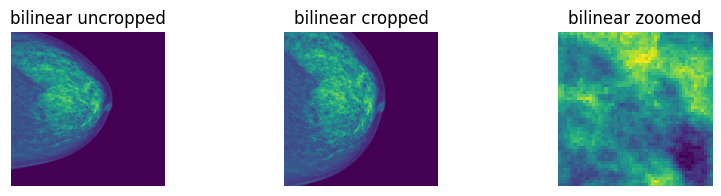

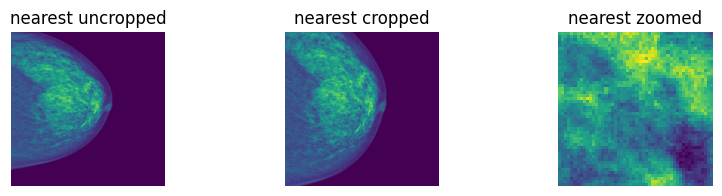

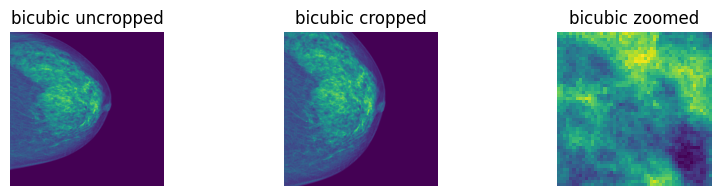

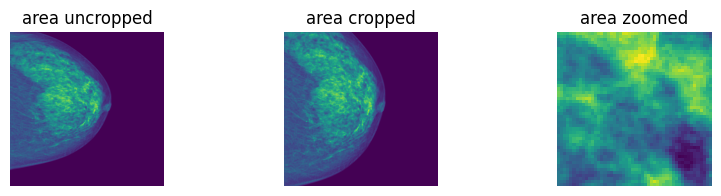

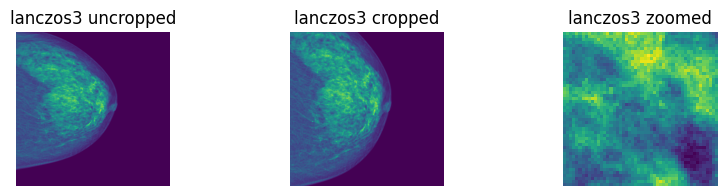

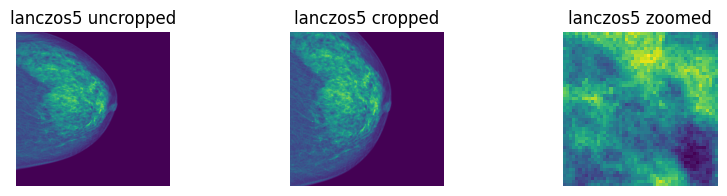

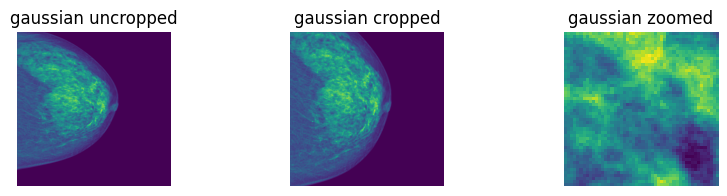

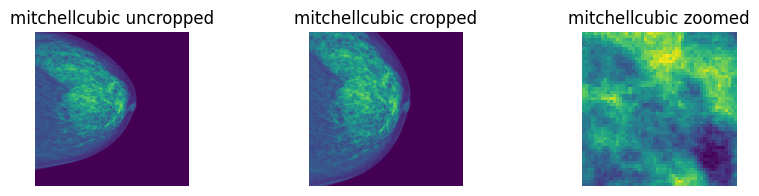

In [2]:
# Create temporary image data generator
def create_dataset(ip, crop):
    dataset = image_dataset_from_directory(
        './data/test/',
        label_mode=None,
        color_mode='grayscale', # DICOM preprocessed into grayscale jpeg images
        batch_size=2,
        image_size=(1000, 1000),
        shuffle=False,
        interpolation=ip,
        crop_to_aspect_ratio=crop
    )
    return dataset

# List of interpolation methods
ip_methods = ['bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian', 'mitchellcubic']

# Plot different interpolation methods
for method in ip_methods:
    f = create_dataset(method, False) # Uncropped
    t = create_dataset(method, True) # Cropped
    
    imagef = [x for x, y in f.take(1)][0]
    imaget = [x for x, y in t.take(1)][0]
    imagezoom = imagef[450:500, 450:500, :]
    
    # Subplotting the three images
    plt.rcParams['figure.figsize'] = [10, 2]
    f, subplt = plt.subplots(1, 3)
    subplt[0].imshow(imagef)
    subplt[0].set_title(method + ' uncropped')
    subplt[0].axis(False)
    subplt[1].imshow(imaget)
    subplt[1].set_title(method + ' cropped')
    subplt[1].axis(False)
    subplt[2].imshow(imagezoom)
    subplt[2].set_title(method + ' zoomed')
    subplt[2].axis(False)
    plt.plot()

It's hard to know exactly which method works best just by looking at it, but I suspect that since **area** interpolation worked really well compared to **bilinear** and **nearest**, the **gaussian** method may be worth testing as well.

**Note: The 4th place solution referenced Lanczos as the preferred method [(source)](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/391208)**

### Image Augmentation

This is what our augmentation layers will be doing in our model. These are built in, and are designed to expand our dataset size artificially. We have to be careful with augmentation, since heavily augmented images can actually work against our goal by hiding the cancerous features we are looking for.

**Note: we can't augment only one side of the classified images, as this may cause our model to rely on augmentation byproducts for predictions**

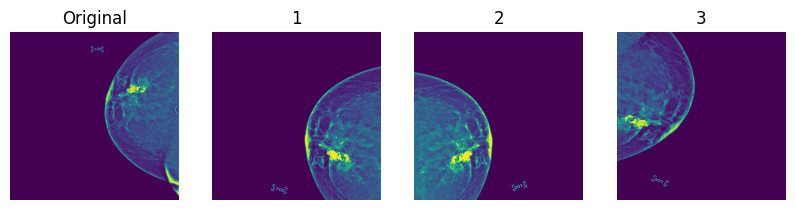

In [3]:
# Keras sequential image augmentation method
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(seed=seed),
#     tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant'),
    tf.keras.layers.RandomRotation(factor=(-0.2,0.2), seed=seed), # Random rotation of -30% to +30%
    tf.keras.layers.RandomZoom(height_factor=(0, -0.3), width_factor=(0, -0.3), seed=seed), # Random zoom in up to 30% 
    tf.keras.layers.RandomBrightness(factor=0.1, seed=seed), # TODO try only increasing brightness instead of decreasing
    tf.keras.layers.RandomContrast(factor=0.3, seed=seed)
])

# Loading unique image, path defined in variables
image = tf.keras.utils.load_img(img_path, color_mode='grayscale')
image = tf.keras.utils.img_to_array(image)
image = tf.image.resize(image, image_size, method='area').numpy().astype('uint8')

# Test the given augmentation method
def repeat(im, func, num, wrap=False, **kwargs):
    plt.rcParams['figure.figsize'] = [10, 3]
    image = im
    f, subplt = plt.subplots(1,num+1)
    subplt[0].imshow(image)
    subplt[0].axis(False)
    subplt[0].set_title('Original')
    image = np.reshape(image, ((1,) + image_shape)) if wrap else image
    for i in range(num):
        image = func(image if wrap else im, **kwargs).numpy().astype("uint8")
        subplt[i + 1].imshow(image[0] if wrap else image)
        subplt[i + 1].set_title(str(i + 1))
        subplt[i + 1].axis(False)
repeat(image, augment, 3, training=True)

Now let's expand the dataset. Each image from the cancer positive collection will produce 17 augmented images, and the cancer negative images will produce 1 augmented image. The balance will become approximately 1 negative to 1 positive classified images. Here's what this script will do:

1. Split images into train, val, test
2. Load images from provided directory
3. Augment images according to our `augment()` sequential Keras method
4. Resize images to `image_size` variable
5. Save images to the appropriate directory

In [4]:
def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('Processing [%s] %s%s %s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

In [5]:
%%time
    
count = 0
total = 0

# Create augmented dataset for given path and number of augmentations
def augment_folder(path, num_augs):
    # Must use global variables because our function is vectorized
    global count
    global total
    
    # Creating path list
    pos_paths = []
    pos_ids = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.endswith('.jpg'):
                pos_paths.append(os.path.join(root, f))
                pos_ids.append(str(f.split('.')[0]))
    
    # Resetting global variables
    pos_paths = np.asarray(pos_paths)
    pos_ids = np.asarray(pos_ids)
    count = 0
    total = len(pos_paths) * (num_augs + 1)
    
    # Train, test, val
    train, val, test = np.multiply((0.8, 0.1, 0.1), len(pos_paths)).astype(int)
    pos_paths_dict = {
        'train': pos_paths[:train],
        'val': pos_paths[train:train+val],
        'test': pos_paths[train+val:]        
    }
    pos_ids_dict = {
        'train': pos_ids[:train],
        'val': pos_ids[train:train+val],
        'test': pos_ids[train+val:]
    }
    
    # Create vectorized functions
    def prog():
        global count
        global total
        count += 1
        progressBar(count + 1, total)
    def func_lar(img_path, ids, p):
        img = tf.keras.utils.load_img(img_path, color_mode='grayscale')
        img = tf.keras.utils.img_to_array(img)
        img = augment(img, training=True)
        img = tf.image.resize(img, image_size, method='area').numpy().astype('uint8')
        cv2.imwrite(os.path.join(p , str(ids) + '.jpg'), img)
        prog()
    def func_lr(img_path, ids, p):
        img = tf.keras.utils.load_img(img_path, color_mode='grayscale')
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, image_size, method='area').numpy().astype('uint8')
        cv2.imwrite(os.path.join(p , str(ids) + '.jpg'), img)
        prog()
    load_augment_resize = np.vectorize(func_lar)
    load_resize = np.vectorize(func_lr)

    # Create script
    def repeat_save(entry):
        for i in range(num_augs):
            save_path = os.path.join(path, 'augmented', entry, str(i))
            os.makedirs(save_path, exist_ok=True)
            load_augment_resize(pos_paths_dict[entry], pos_ids_dict[entry], save_path)
    
    # Run the script
    for entry in pos_paths_dict:
        # Augment and save
        repeat_save(entry) 
        
        # Resize and save
        save_path = os.path.join(path, 'augmented', entry, 'original')
        os.makedirs(save_path, exist_ok=True)
        load_resize(pos_paths_dict[entry], pos_ids_dict[entry], save_path)
        
    print('Processed.')
    
# # Running this script will augment the datatset and may take over 2 hours 
# augment_folder('D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images0/', 1) # Create 1 augmented images per one original
# augment_folder('D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images1/', 17) # Create 17 augmented images per one original

CPU times: total: 0 ns
Wall time: 0 ns


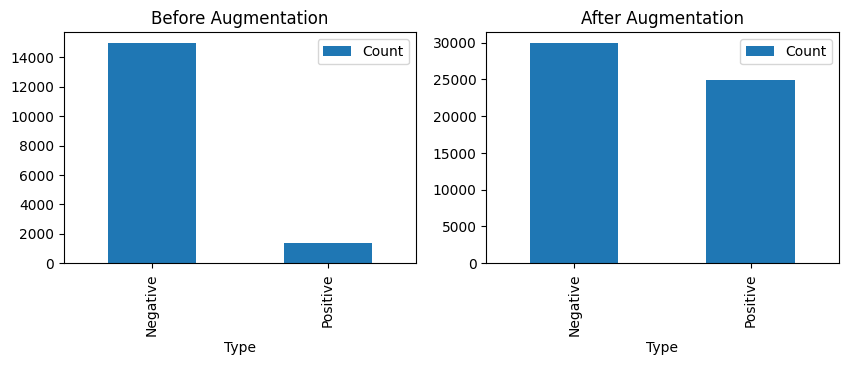

In [6]:
# Count the number of images in the given folder
def count_images(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.endswith('.jpg'):
                count += 1 
    return count

# Create image count dataframes for original folder
balance_df = pd.DataFrame(
    data = [['Negative', count_images('D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images0/0/')], 
            ['Positive', count_images('D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images1/1/')]],
    columns = ['Type', 'Count']
)

# Create image count dataframes for augmented folder
balance_df_aug = pd.DataFrame(
    data = [['Negative', count_images('D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images0/images0r v3/')], 
            ['Positive', count_images('D:/MachineLearning/RSNA Kaggle/data/rsna-mixed-raw/images1/images1r v3/')]],
    columns = ['Type', 'Count']
)

# Plot the dataframes
plt.rcParams['figure.figsize'] = [10, 3]
f, subplt = plt.subplots(1,2)
balance_df.plot.bar(x='Type', y='Count', title='Before Augmentation', ax=subplt[0])
balance_df_aug.plot.bar(x='Type', y='Count', title='After Augmentation', ax=subplt[1])
plt.show()

## Class weights

Another possible approach is to use an imbalanced dataset and create class weights to mitigate this imbalance. These weights will become inputs into our `model.fit()` function call. Instead, we have opted to use a mostly balanced class distribution.

In any case, here is what creating class weights looks like:

In [7]:
# # There is a data inbalance
# # We need to create a weight bias to pass to model.fit()
# # Files, and their matching class index, are in alphanumerical order

# # Create labels array
# train_labels = np.concatenate([y for _, y in train_data.as_numpy_iterator()], axis=0)

# # Create weights numerator and denomenator
# num_files = np.sum(train_labels, axis = 0)
# total_files = np.sum(train_labels)
# print(np.shape(num_files))
# print(num_files)
# print(total_files)

# # Create class_weight dictionary
# class_weight = {}
# for i in range(np.shape(num_files)[0]):
#     class_weight[i] = total_files/num_files[i] # Weighted by 1/ratio or total/count

# print('Class weights: {}'.format(class_weight))

### Creating Training and Validation Set

In [8]:
train_data, val_data = image_dataset_from_directory(
    folder_path,
    subset='both',
    label_mode='binary',
    color_mode=color_mode,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed,
    validation_split=0.2,
    interpolation=interpolation,
    crop_to_aspect_ratio=crop_to_aspect_ratio
)

Found 4855 files belonging to 2 classes.
Using 3884 files for training.
Using 971 files for validation.


### Adding False Positive Test Set

We should also test our model against an image dataset that is populated by only negative cases to see how it fairs against the imbalanced data it will experience in production (or in this case Kaggle's submission run).

In [9]:
test_data = image_dataset_from_directory(
    './data/false_pos/',
    label_mode=None,
    color_mode=color_mode,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed,
    interpolation=interpolation,
    crop_to_aspect_ratio=crop_to_aspect_ratio
)

Found 1000 files belonging to 1 classes.


## Image Standardization/Normalization

We need to preprocess our images directly within the model since this step was skipped during collection. That means modifying our images so that they all have a similar pixel array distribution. There are many ways to do this step, but here are some of the easiest functions available from `TensorFlow`:
- `tf.image.per_image_standardization()` 
- `tf.keras.applications.imagenet_utils.preprocess_input()`

Let's first take a look at what the `per_image_standardization()` function does:

Max Pixel Value: 6.413900375366211
Min Pixel Value: -0.5442445278167725


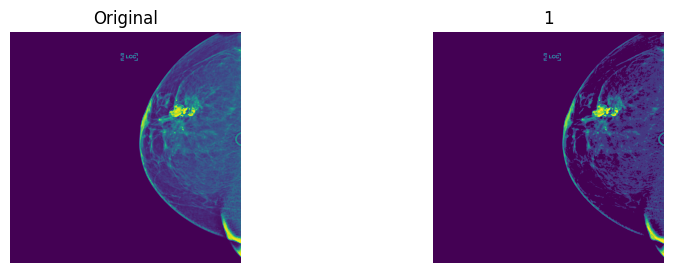

In [10]:
def standardize(image):
    # Per image standardization
    image = tf.image.per_image_standardization(image)
    print('Max Pixel Value: {}'.format(np.max(image)))
    print('Min Pixel Value: {}'.format(np.min(image)))
    return image

repeat(image, standardize, 1, wrap=True)

The results look good. But there are negative values created by the operation. Let's crop those out and and expand the image to fill the 255 uint8 standard:

Max Pixel Value: 255.0
Min Pixel Value: 0.0


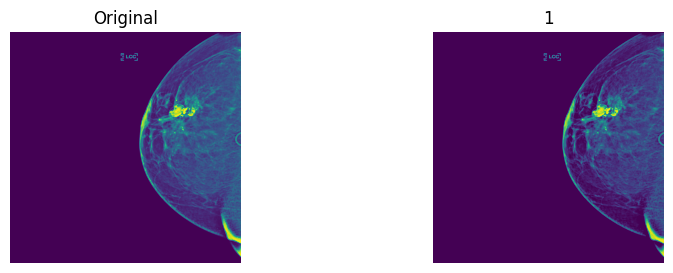

In [11]:
def standardize(image):
    # Per image standardization
    image = tf.image.per_image_standardization(image)
    
    # Set values less than 0 to 0
    image = tf.maximum(image, 0)
    
    # Expand to 255.0
    image = image / tf.reduce_max(image) * 255
    print('Max Pixel Value: {}'.format(np.max(image)))
    print('Min Pixel Value: {}'.format(np.min(image)))
    return image

repeat(image, standardize, 1, wrap=True)

Let's then take a look at the recommended normalization process `tf.keras.applications.imagenet_utils.preprocess_input()`:

Max Pixel Value: 2.640000104904175
Min Pixel Value: -2.1179039478302


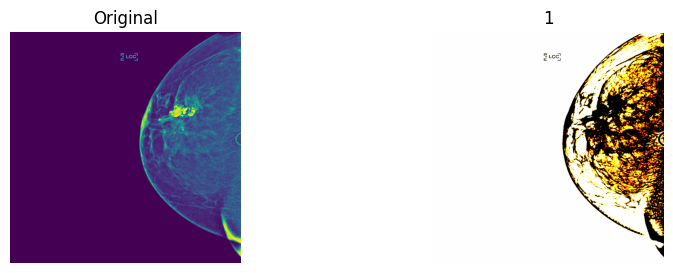

In [12]:
def torch(image):
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    print('Max Pixel Value: {}'.format(np.max(image)))
    print('Min Pixel Value: {}'.format(np.min(image)))

    return image

repeat(image, torch, 1, wrap=True)

As the name suggests, it's as if there's a bright light penetrating the object and the higher density parts appear much darker.

What if we combine the two steps:

Max Pixel Value: 2.640000104904175
Min Pixel Value: -2.1179039478302


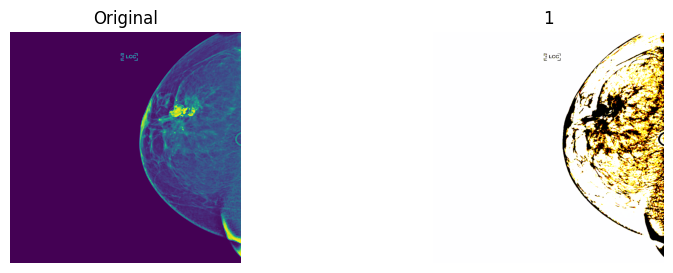

In [13]:
def normalize(image):
    # Per image standardization
    image = tf.image.per_image_standardization(image)
    # Set values less than 0 to 0
    image = tf.maximum(image, 0)
    # Expand to 255.0
    image = image / tf.reduce_max(image) * 255
    
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    print('Max Pixel Value: {}'.format(np.max(image)))
    print('Min Pixel Value: {}'.format(np.min(image)))

    return image

repeat(image, normalize, 1, wrap=True)

Bringing it all together, we get an image that contains pixel values that are only greater than the mean (high density objects), that is then further processed by the preferred imagenet normalization method.

We can even apply the simple standardization method multiple times, each time adding more definition to the high density objects:

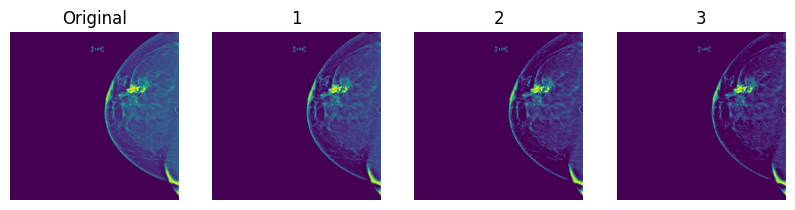

In [14]:
def standardize(image):
    # Per image standardization
    image = tf.image.per_image_standardization(image)
    # Set values less than 0 to 0
    image = tf.maximum(image, 0)
    # Expand to 255.0
    image = image / tf.reduce_max(image) * 255
    
    return image

repeat(image, standardize, 3, wrap=True)

We can even remove empty space within the image:

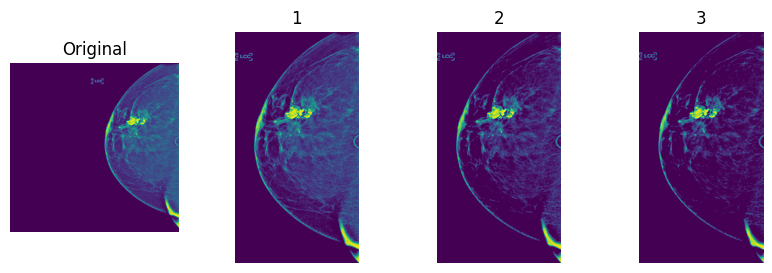

In [15]:
def remove_space(image):
    # Find the x indices where the sum of the column is greater than 100
    sumx = tf.reduce_sum(image, axis=1)
    indicesx = tf.where(tf.greater(sumx, 100)).numpy()
    
    # Find the y indices where the sum of the row is greater than 100
    sumy = tf.reduce_sum(image, axis=2)
    indicesy = tf.where(tf.greater(sumy, 100)).numpy()
    
    # Check to see if these conditions actually exist
    if len(indicesx) > 0: # We only really have to check once
        x1 = indicesx[0][1]
        x2 = indicesx[-1][1]
        
        y1 = indicesy[0][1]
        y2 = indicesy[-1][1]
    
    # Crop the image
    image = tf.image.crop_to_bounding_box(
        image, 
        offset_height=y1, 
        offset_width=x1, 
        target_height=y2-y1, 
        target_width=x2-x1
    )
    
    return image

def sample_norm(image):
    image = standardize(image)
    image = remove_space(image)
    return image

repeat(image, sample_norm, 3, wrap=True)

One thing to note is that removing space at this stage isn't as powerful, since the image has already been resized by the `image_dataset_from_directory()` function. It would be best to remove spaces before saving during image collection. 

We can try all types of normalization processes and can consider this a hyperparamater while training. For example, we could standardize 3 times, then torch the image:

Torch only:


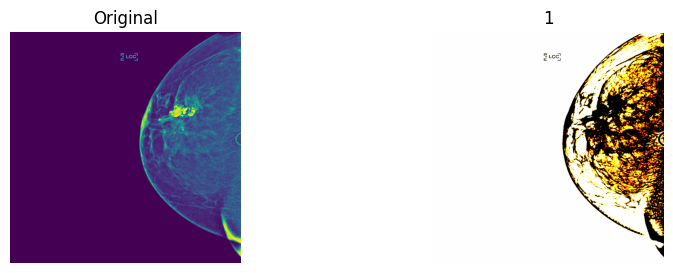

In [16]:
def standardize(image):
    # Per image standardization
    image = tf.image.per_image_standardization(image)
    # Set values less than 0 to 0
    image = tf.maximum(image, 0)
    # Expand to 255.0
    image = image / tf.reduce_max(image) * 255

    return image

def torch(image):    
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    
    return image

def sample_norm(image):
    image = standardize(image)
    image = standardize(image)
    image = standardize(image)
    image = torch(image)
    
    return image

print('Torch only:')
repeat(image, torch, 1, wrap=True)

Standardize 3 times then torch:


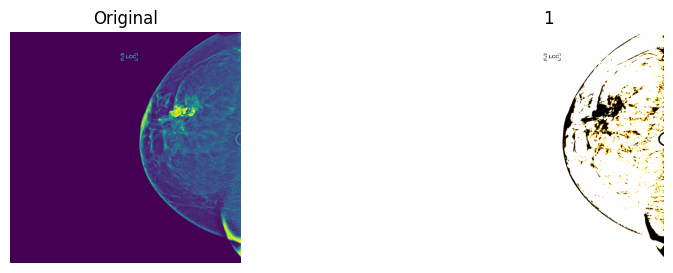

In [17]:
print('Standardize 3 times then torch:')
repeat(image, sample_norm, 1, wrap=True)

After testing, however, it seems that simply torching the image gives the best submission results:

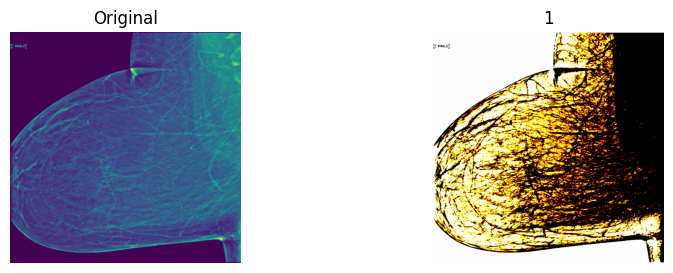

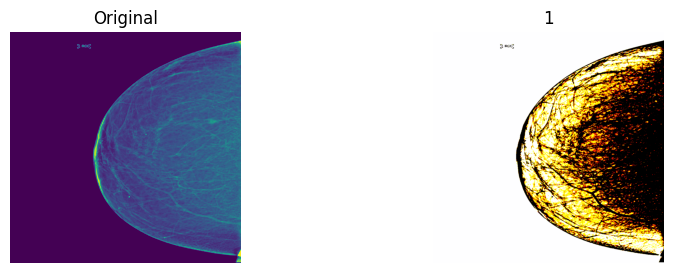

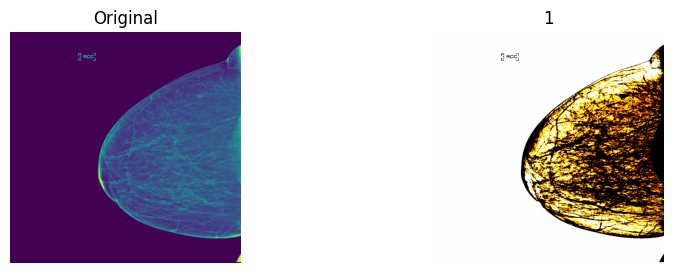

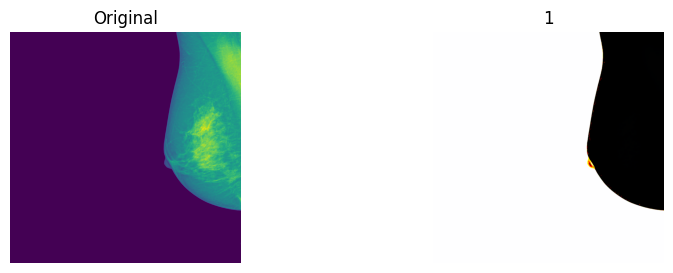

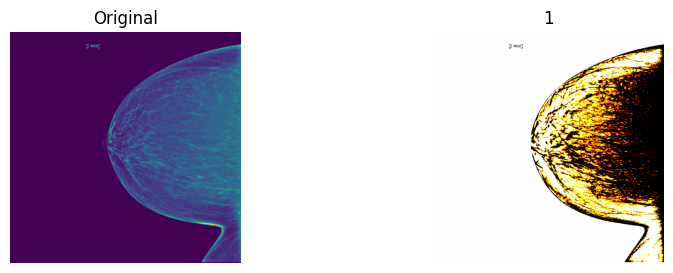

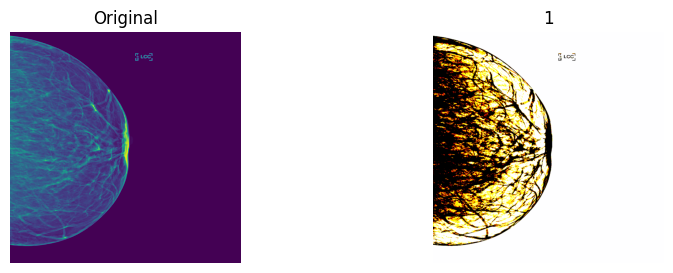

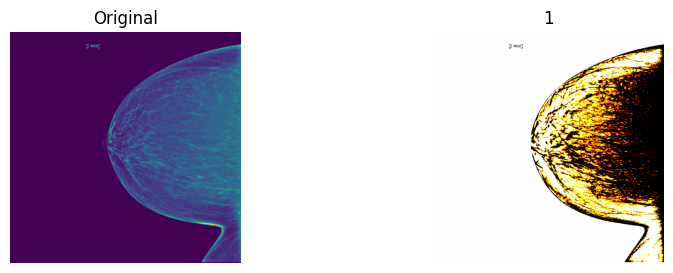

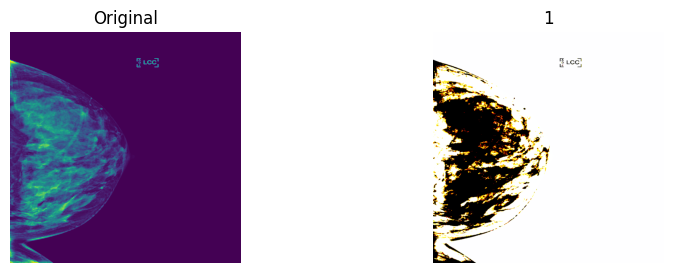

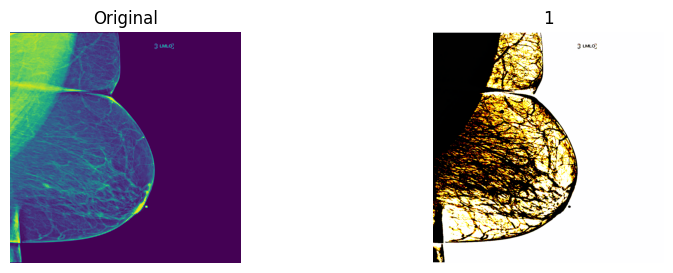

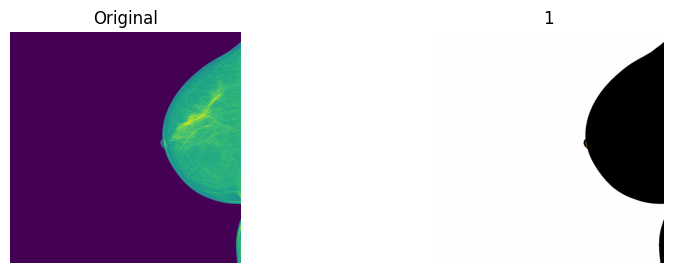

In [18]:
for i in range(10):
    repeat([x for x, y in train_data.take(1)][0][0], torch, 1, wrap=True)

## Creating Patient Dataset for Ensemble Model

In [19]:
def create_pat_datasets():
    # Sort and reduce the CSV with provided image list
    def sort_df(image_id):
        pat_df = pd.DataFrame()
        pat_df['image_id'] = image_id
        pat_df = pat_df.set_index('image_id').join(csv)
        return pat_df

    ### One Hot Encoding ###
    # Fit the encoding function and return attributes
    def fit_encode(df):
        pat_encoder = OneHotEncoder(sparse_output=False)
        pat_encoder.fit(df)

        return pd.DataFrame({
            'categories_': pat_encoder.categories_, 
            '_infrequent_enabled': pat_encoder._infrequent_enabled,
            'drop_idx_': pat_encoder.drop_idx_,
            '_n_features_outs': pat_encoder._n_features_outs,
            'feature_names_in_': pat_encoder.feature_names_in_
        })
    # Encode a single column with given attributes
    def encode(df, attributes):
        pat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        pat_encoder.categories_ = [attributes['categories_']]
        pat_encoder._infrequent_enabled = attributes['_infrequent_enabled']
        pat_encoder.drop_idx_ = attributes['drop_idx_']
        pat_encoder._n_features_outs = [attributes['_n_features_outs']]
        pat_encoder.feature_names_in_ = [attributes['feature_names_in_']]
        pat_enc = pat_encoder.transform(df)

        return pat_enc
    
    # Encode the entire dataframe with given attributes
    def create_encoded(pat_df_enc, enc_attr):
        pat_encoded = pd.DataFrame()
        for feature in enc_attr['feature_names_in_']:
            attr = enc_attr[enc_attr['feature_names_in_'] == feature].to_dict('records')[0]
            mux = pd.MultiIndex.from_product([[feature], attr['categories_']])
            enc = pd.DataFrame(data=encode(pat_df_enc[[feature]], attr), columns=mux)
            pat_encoded = pd.concat([pat_encoded, enc], axis=1)
        return pat_encoded
    
    # Remove extra features
    def ohe_prep(pat_df):
        return pat_df[['site_id', 'laterality', 'view', 'implant', 'machine_id']]
    
    # Image order follows this list
    image_id_train = [int(os.path.basename(fp).split('.')[0]) for fp in train_data.file_paths]
    vfp = val_data.file_paths[:val_data.shard(num_shards=2, index=0).cardinality().numpy()] # sharding does not shuffle data
    image_id_val = [int(os.path.basename(fp).split('.')[0]) for fp in vfp]
    
    # Sort csv and drop extra entries
    pat_df_train = sort_df(image_id_train)
    pat_df_val = sort_df(image_id_val)

    # Removing features unavailable during test and preparing for one hot encoding
    pat_prep_train = ohe_prep(pat_df_train)
    pat_prep_val = ohe_prep(pat_df_val)
    
    # Gather Attributes (train set only)
    encoder_attributes = pd.DataFrame()
    for col in pat_prep_train:
        encoder_attributes = pd.concat([encoder_attributes, fit_encode(pat_prep_train[[col]])]).reset_index(drop=True)
        
    # Encoding
    pat_encoded_train = create_encoded(pat_prep_train, encoder_attributes)
    pat_encoded_val = create_encoded(pat_prep_val, encoder_attributes)

    # Adding age scaled down 1/100 years
    pat_encoded_train = pd.concat([pat_df_train[['age']].reset_index(drop=True) / 100, pat_encoded_train], axis=1)
    pat_encoded_val = pd.concat([pat_df_val[['age']].reset_index(drop=True) / 100, pat_encoded_val], axis=1)
    
    # Adding labels (target)
    pat_encoded_train = pd.concat([pat_encoded_train, pat_df_train[['cancer']].reset_index(drop=True)], axis=1)
    pat_encoded_val = pd.concat([pat_encoded_val, pat_df_val[['cancer']].reset_index(drop=True)], axis=1)

    return pat_encoded_train, pat_encoded_val, encoder_attributes

In [20]:
# # This only works for the RSNA dataset
# pat_encoded_train, pat_encoded_val, encoder_attributes = create_pat_datasets()
# pat_encoded_train

## Model Callbacks

In [21]:
# Live plotting for training metrics
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

# The Model

This is where all the play-testing of our model occurred. Our local machine isn't able to compute large images, but we can gauge what works and what doesn't using smaller images and then take our learnings to the cloud. Most of the testing happened on 700 pixel and 1000 pixel (squared) images using ResNet50V2, EfficientNetV2, and ConvNeXtV2.

In [22]:
# Clearing previous session to clear up RAM
tf.keras.backend.clear_session()

# Creating learning rate decay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=1000,
    decay_rate=0.90)

# Optimization function
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Configuring base model
base_model = convnext.ConvNeXtV2Tiny(
    input_shape=image_size + (3,),
    pretrained='imagenet21k-ft1k',
    num_classes=0,
)
base_model.trainable = True

# Inputs
inputs = Input(shape=image_shape)

# Live image augmentation
x = RandomFlip(seed=seed)(inputs)

# Image normalization
x = torch(x)

# Base model layer
x = base_model(x)

# Dropout
x = SpatialDropout2D(0.7)(x)

# Pooling layer
x = GlobalAveragePooling2D()(x)

# Dropout
x = Dropout(0.3)(x)

# We have binary classification (positive and negative)
predictions = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics='binary_accuracy')

C:\Users\AbEl-\anaconda3\envs\keras\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


>>>> Load pretrained from: C:\Users\AbEl-\.keras\models\convnext_v2_tiny_384_imagenet21k-ft1k.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 1000, 1)]   0         
                                                                 
 random_flip (RandomFlip)    (None, 1000, 1000, 1)     0         
                                                                 
 tf.repeat (TFOpLambda)      (None, 1000, 1000, 3)     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 1000, 1000, 3)     0         
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 1000, 1000, 3)    0         
 bda)                                                            
                                                                 
 tf.nn.bias_add (TFOpLambda)  

### Train and Save

In [23]:
# fitModel = model.fit( train_data
#                     , validation_data=val_data.shard(num_shards=2, index=0)
#                     , epochs=30
#                     , batch_size=batch_size
#                     , verbose=1
# #                     , class_weight=class_weight
#                     , callbacks=[PlotLearning()]
#                     )

![image](training_loss.png)

In [24]:
# model.save('ConvNext70sgv700px', save_format='h5')

# Analysis

Let's load our cloud-trained model and see how it holds up against our test dataset (the same train, validation, and test datasets are used).

In [25]:
model = tf.keras.models.load_model('ConvNextAugLowL2', custom_objects={'base_model': base_model})

### Example Test Image

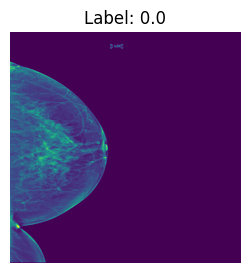

In [26]:
for image, label in val_data.shard(num_shards=2, index=1).take(1):
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title('Label: {}'.format(label[0].numpy()[0]))
    plt.axis('off')

### Inference

In [27]:
prediction = model.predict(val_data.shard(num_shards=2, index=1))
false_positive = model.predict(test_data)

500/500 [==============================] - 102s 199ms/step


### Preparing For Analysis

In [28]:
prediction = np.asarray(prediction).reshape((len(prediction),np.shape(prediction)[1]))
labels = np.concatenate([y for x, y in val_data.shard(num_shards=2, index=1)], axis=0)

false_positive = np.asarray(false_positive).reshape((len(false_positive),np.shape(false_positive)[1]))
false_positive_labels = np.zeros(np.shape(false_positive))

print(prediction.shape)
print(labels.shape)
print(false_positive.shape)
print(false_positive_labels.shape)

(485, 1)
(485, 1)
(1000, 1)
(1000, 1)


### Analysis Functions

In [29]:
# Plot the predictions against the labels
def plot_pred(actual, predicted, gate=0.5, length=100):
    plt.rcParams['figure.figsize'] = [10, 2]
    plot_num = 1
    
    for i, col in enumerate(predicted.T):
#         if (i == 0):
#             continue
        plt.subplot(len(predicted.T), 1, plot_num)
        plt.plot(list(range(len(predicted)))[-length:], predicted[-length:,i], label='Predicted')
        plt.subplot(len(predicted.T), 1, plot_num)
        plt.plot(list(range(len(predicted)))[-length:], actual[-length:,i], label='Actual')
        plt.axhline(gate, linestyle='dashed', label='Gate', color='grey')
        plt.ylim((0, 1))
        plot_num += 1
        plt.legend(loc='upper right')
        plt.ylabel('Prediction')
    plt.xlabel('Image')
    plt.show()

In [30]:
# Get class accuracy and detection accuracy of the predictions
# Class accuracy: true positive / (true positive + false positive) * 100
# Detection accuracy/TPR/Recall/Sensitivity: true positive / (true positive + false negative) * 100
def get_accuracy(actual, pred, verbosity = 0, n = 0):
    # Detect good predictions
    good_predictions = []
    for i in range(len(pred)):
        if any(pred[i] == actual[i]):
            good_predictions.append(int((pred[i,n] == actual[i,n])))
        else:
            good_predictions.append(0)        
    good = np.sum(good_predictions, axis = 0)
    bad = len(good_predictions) - good
    good_predictions = np.asarray(good_predictions).reshape((len(good_predictions), np.shape(actual)[1]))
    good_classifications = np.sum(good)/(np.shape(actual)[0]*np.shape(actual)[1])*100
    class_classifications = []
        
    # Totaling the numbers
    total_pred = np.sum(pred, axis = 0)[0]
    total_actual = np.sum(actual, axis = 0)[0]
    total_good = np.sum((pred * good_predictions), axis = 0)[0]
    total_bad = total_pred - total_good
    class_accuracy = total_good / total_pred * 100
    detection_accuracy = ((total_good/total_actual)*100 if total_actual > 0 else 100)
    fpr = total_bad / len(actual) * 100
    
    # Verbose printing
    if verbosity > 0:
        print('\tTotal good/bad classifications: {}/{}'.format(good, bad))
        print('\tGood classifications: {}%'.format(good_classifications))
#         print('\tBad classifications: {}%'.format(np.sum(bad)/(np.shape(actual)[0]*np.shape(actual)[1])*100))
        print('\tCancer good/total classifications: {}/{}'.format(total_good, total_pred))
        print('\tCancer classification accuracy: {}%'.format(class_accuracy))
        print('\tCancer detection accuracy (TPR): {}%'.format(detection_accuracy))
        print('\tFalse positive rate (FPR): {}%'.format(fpr))
        
    return good_classifications, class_accuracy, detection_accuracy

In [31]:
# Test the accuracy of provided prediction gate value using the get_accuracy() function above
def test_gate(labels, preds, gate):
    preds = (preds >= (gate)).astype(int)
    
    if not all(preds == 1) and not all(preds == 0):
        f1 = f1_score(labels, preds)
        acc, class_acc, detection_acc = get_accuracy(labels, preds)
    else:
        f1 = np.nan
        acc = np.nan
        class_acc = np.nan
        detection_acc = np.nan
    return acc, class_acc, detection_acc, f1

In [32]:
# Plot the accuracy of different prediction gate values
def plot_acc():
    plt.rcParams['figure.figsize'] = [10, 5]
    x_axis = np.arange(0.1, 0.9, 0.01)
    acc = []
    class_acc = []
    detection_acc = []
    false_acc = []
    pf1 = []
    
    # Test gate values of 0.1 through 0.9 in intervals of 0.01
    for i in x_axis:
        a, b, c, f1 = test_gate(actual.copy(), prediction.copy(), i)
        d, _, _, _ = test_gate(false_positive_labels.copy(), false_positive.copy(), i)
        acc.append(a)
        class_acc.append(b)
        detection_acc.append(c)
        false_acc.append(d)
        pf1.append(f1)
    class_acc = np.asarray(class_acc)
    detection_acc = np.asarray(detection_acc)
    false_acc = np.asarray(false_acc)
    acc = np.asarray(acc)
    pf1 = np.asarray(pf1)
    
    # Finding the intersect key (https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value)
    try:
        intersect = np.argwhere(np.diff(np.sign(acc-false_acc))).flatten()
        intersect = np.min(intersect[~np.isnan(acc[intersect])])
    except:
        intersect = 0
    
    # Plot accuracies
#     plt.plot(x_axis, acc, label='Accuracy')
    plt.plot(x_axis, class_acc, label='Cancer Classification Accuracy')
    plt.plot(x_axis, detection_acc, label='Cancer Detection Accuracy (TPR)')
    plt.plot(x_axis, 100 - false_acc, label='False Positive Rate (FPR)')
    plt.plot(x_axis, 100 * pf1, label='F1-Score')
    
    # Try plotting the intersect key (sometimes it doesn't exist)
    try:
        gate1 = x_axis[intersect]
        gate2 = x_axis[np.where(class_acc == np.nanmax(class_acc))[0][0]]
        gateavg = (gate1 + gate2) / 2
        plt.axvline(gate1, linestyle='dashed', label='Suggested Gate Range', color='grey')
        plt.axvline(gate2, linestyle='dashed', color='grey')
        plt.axvline(gateavg, linestyle='solid', label='Suggested Gate Value', color='grey')
        print('Suggested Gate Value: {}'.format(gateavg))
    except:
        gate = 0.5
        gateavg = 0.5
        pass
    
    # Plot meta
    plt.legend()
    plt.xlim((0, 1))
    plt.ylim((0, 100))
    plt.xlabel('Gate Value')
    plt.ylabel('Percent %')
    plt.title('Metrics for Different Gate Values')
    plt.grid(True)
    plt.show()
    return gateavg

In [33]:
# Find the normal distribution function of given array
def norm_dist(x, y):
    mu, std = norm.fit(y)
    return norm.pdf(x, loc=mu, scale=std) * 70, mu, std

# Plot the distribution bins along with the normal distribution functions
def plot_dist(bins = 10):
    x = np.arange(0, 1, 1/bins)
    preds0 = prediction[labels == 0]
    preds1 = prediction[labels == 1]
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(7, 7))
    
    # Prediction bins for negative cases
    ax[0, 0].hist(preds0, bins=10)
    ax[0, 0].set_title('Predictions for Negative Cases')
    ax[0, 0].grid(True)
    
    # Prediction bins for positive cases
    ax[0, 1].hist(preds1, bins=10)
    ax[0, 1].set_title('Predictions for Positive Cases')
    ax[0, 1].grid(True)
    
    # Prediction bins for false-positive test set
    ax[1, 0].hist(false_positive, bins=30)
    ax[1, 0].set_title('False-Positive Test')
    ax[1, 0].grid(True)
    
    # Prediction distributions for all test data
    ax[1, 1].plot(x, norm_dist(x, preds0)[0], label='Negative Cases', color='blue')
    ax[1, 1].axvline(norm_dist(x, preds0)[1], linestyle='dashed', color='blue')
    ax[1, 1].plot(x, norm_dist(x, preds1)[0], label='Positive Cases', color='orange')
    ax[1, 1].axvline(norm_dist(x, preds1)[1], linestyle='dashed', color='orange')
    ax[1, 1].plot(x, norm_dist(x, false_positive)[0], label='False Positive', color='green')
    ax[1, 1].axvline(norm_dist(x, false_positive)[1], linestyle='dashed', color='green')
    ax[1, 1].legend(loc='upper right')
    ax[1, 1].set_title('Normal Distribution of Predictions')
    ax[1, 1].grid(True)
    
    fig.supxlabel('Prediction Value')
    fig.supylabel('Count')
    plt.show()

### Prediction Distribution

Let's look at the distribution of our model's predictions. There are three main categories to observe:
1. Predictions when the test set's label is cancer negative
2. Predictions when the test set's label is cancer positive
3. Predictions for the false-positive test set (labels are all negative)

We expect to see as wide of a gap between the mean of our predictions as possible. Ideally, the negative cases distribution mean will be close to 0, the positive close to 1, and the false-positive close to 0. We also hope to see the normal distribution of false-positive predictions aligning with the negative test set - this indicates that the model has high seperability and it really is detecting cancerous features which suggests good performance.

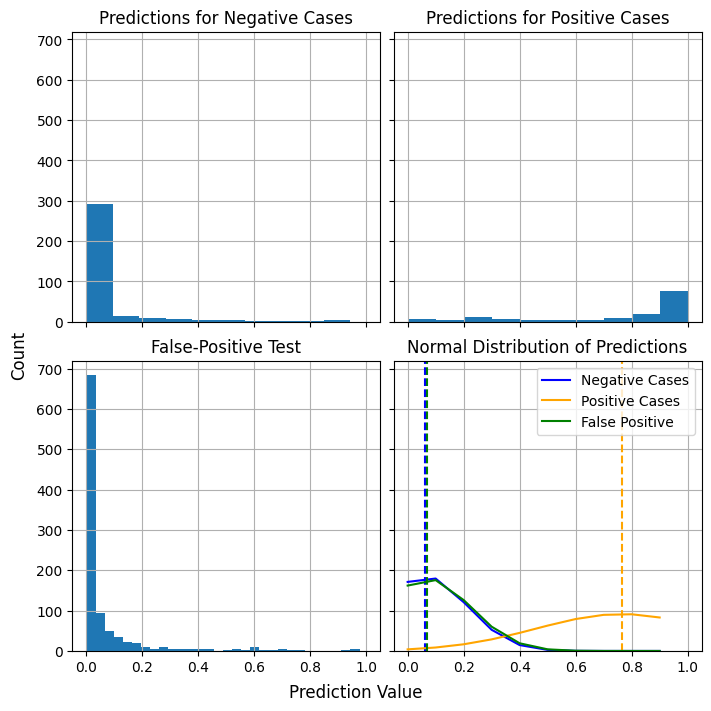

In [34]:
plot_dist()

### Example Gate

Although it's possible to use our raw prediction values as probabilities for this competition, we will convert our predictions to binary values:
- Negative = 0
- Positive = 1

Doing this reduces the effect of non-zero true-negative predictions on our score, of which will be the majority of predictions in a submission inference. In our training dataset alone, the ratio of negative to positive images was on the order of 50 to 1.

We will make this conversion using a *gate value* instead of simply rounding our prediction values:
- Lesser than gate value = 0
- Greater than gate value = 1

It's important to do this because we do not want to treat cases that the model is unsure about as 'possible' cancer cases. Not yet at least. A model like that will need further processing, perhaps by an ensemble model.

In [35]:
# Gate our predictions
def gate(pred):
    pred[:,0] = (pred[:,0] >= 0.70).astype(int) # Cancer predicted if likelihood is > gate value
    return pred

predictions = gate(prediction.copy())
actual = labels

print("Predictions: ")
print(prediction[-3:])
print('Gated Predictions: ')
print(predictions[-3:])
print("Actual: ")
print(actual[-3:])

Predictions: 
[[0.03921913]
 [0.0218177 ]
 [0.9986533 ]]
Gated Predictions: 
[[0.]
 [0.]
 [1.]]
Actual: 
[[1.]
 [0.]
 [1.]]


In [36]:
print('Prediction Accuracy Metrics:')
_, _, _ = get_accuracy(actual, predictions, 1)

print('\nFalse Positive Accuracy Metrics:')
_, _, _ = get_accuracy(false_positive_labels, gate(false_positive.copy()), 1)

Prediction Accuracy Metrics:
	Total good/bad classifications: 436/49
	Good classifications: 89.89690721649485%
	Cancer good/total classifications: 104.0/110.0
	Cancer classification accuracy: 94.54545454545455%
	Cancer detection accuracy (TPR): 70.74829931972789%
	False positive rate (FPR): 1.2371134020618557%

False Positive Accuracy Metrics:
	Total good/bad classifications: 984/16
	Good classifications: 98.4%
	Cancer good/total classifications: 0.0/16.0
	Cancer classification accuracy: 0.0%
	Cancer detection accuracy (TPR): 100%
	False positive rate (FPR): 1.6%


These metrics help us determine a few things:
- Whether cases labeled as cancerous are actually cancerous
- How good our model is at detecting cancer when it is present

What we're really looking for is both a high detection (TPR) and classification accuracy for the balanced dataset, as well as a low false positive rate (FPR).

### Determining Good Gate Values

In order to maximize our model's effectiveness, we need to study how different gate values affect our prediction metrics.

Suggested Gate Value: 0.5349999999999998


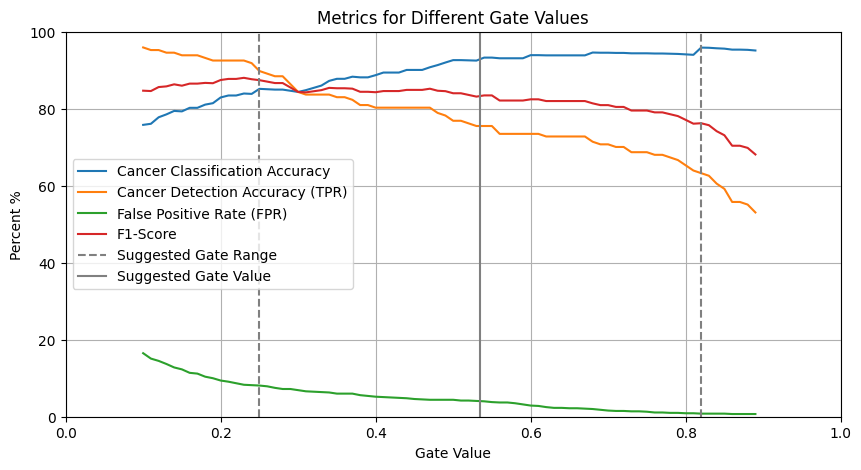

In [37]:
gate_value = plot_acc()

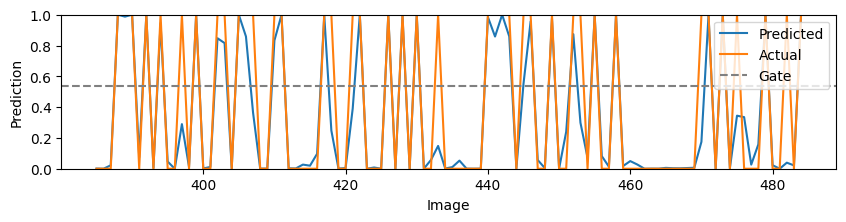

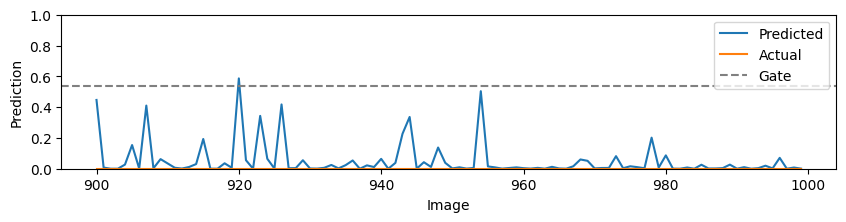

In [38]:
plot_pred(labels, prediction, gate_value)
plot_pred(false_positive_labels, false_positive, gate_value)

# Verifying Our Prediction Values For Deployment

This step allows us to compare a model's prediction values with our deployed inference values just to make sure everything is working properly! We just compare the prediction array below with the prediction array found on the submission/collection notebook.

In [39]:
test_data2 = image_dataset_from_directory(
    './data/test/',
    label_mode=None,
    color_mode=color_mode,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
    seed=seed,
    interpolation=interpolation,
    crop_to_aspect_ratio=crop_to_aspect_ratio
)

test_data2_pred = model.predict(test_data2)

Found 4 files belonging to 1 classes.
2/2 [==============================] - 1s 194ms/step


In [40]:
test_data2_pred

array([[0.41467336],
       [0.01007901],
       [0.10087505],
       [0.04023108]], dtype=float32)